In [29]:
from collections import Counter
import pickle
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Input, add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


## Preprocess Data

In [17]:
sentence_list = []
sentence_tag_list = []
sentence = []
sentence_tag = []

with open('./ner_data/msra_train.txt') as f:
    for line in f:
        if len(line) > 2:
            char, tag = line.split()
            sentence.append(char)
            sentence_tag.append(tag)
        else:
            sentence_list.append(sentence)
            sentence = []
            sentence_tag_list.append(sentence_tag)
            sentence_tag = []

In [18]:
char_set = set([char for sent in sentence_list for char in sent])
id_char_dict = {(idx+2): elem[0] for idx, elem in enumerate(char_set)}

id_char_dict[0] = "<PAD>" # special token for padding
id_char_dict[1] = "<UNK>" # special token for unknown(not in the dictionary)

char_id_dict = {v: k for k, v in id_char_dict.items()}

In [19]:
import pickle

In [20]:
# save for later use
with open('./ner_data/processed/msra_char_id_dict.pkl', 'wb') as f:
    pickle.dump((char_id_dict, id_char_dict), f)

In [21]:
print(sentence_list[1692])
print(sentence_tag_list[1692])

['２', '、', '国', '家', '林', '业', '局', '副', '局', '长', '李', '育', '才', '只', '能', '通', '过', '卫', '星', '电', '话', '协', '调', '云', '南', '空', '运', '洒', '水', '外', '挂', '件', '。']
['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [22]:
with open('./ner_data/processed/msra_encoded_sentence.pkl', 'wb') as f:
    pickle.dump((sentence_list, sentence_tag_list), f)

In [23]:
id_tag_dict = {idx: v for idx, v in enumerate(sorted( list(tag_set) )[::-1])}
tag_id_dict = {v: k for k, v in id_tag_dict.items()}

In [24]:
def encode_sentence(sentence_list, char_id_dict=char_id_dict):
    sentence_encoded_list = []
    for s in sentence_list:
        sentence_encoded = []
        for w in s:
            c = char_id_dict.get( w, char_id_dict.get('<UNK>') )
            sentence_encoded.append(c)
        sentence_encoded_list.append(sentence_encoded)
    return sentence_encoded_list

def encode_tag(tag_list, tag_id_dict=tag_id_dict):
    tag_encoded_list = []
    for s in tag_list:
        tag_encoded = []
        for w in s:
            c = tag_id_dict.get(w)
            tag_encoded.append(c)
        tag_encoded_list.append(tag_encoded)
    return tag_encoded_list

def decode_sentence_single(sentence, id_char_dict=id_char_dict):
    decode_sent = []
    for c in sentence:
        decode_sent.append(id_char_dict.get(c, '<UNK>'))
    return decode_sent

def decode_tag_single(tags, id_tag_dict=id_tag_dict):
    decode_tag = []
    for row in tags:
        idx = np.argmax(row)
        decode_tag.append(id_tag_dict.get(idx))
    return decode_tag

In [25]:
tag_set

{'B-LOC', 'B-ORG', 'B-PER', 'I-LOC', 'I-ORG', 'I-PER', 'O'}

In [26]:
id_tag_dict

{0: 'O',
 1: 'I-PER',
 2: 'I-ORG',
 3: 'I-LOC',
 4: 'B-PER',
 5: 'B-ORG',
 6: 'B-LOC'}

## Analysis Data

In [88]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [150]:
plt.style.use('fivethirtyeight')

{'whiskers': [<matplotlib.lines.Line2D at 0x15153d0b8>,
 'caps': [<matplotlib.lines.Line2D at 0x15153d9e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x151cf0ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x1515452e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x151545748>],
 'means': []}

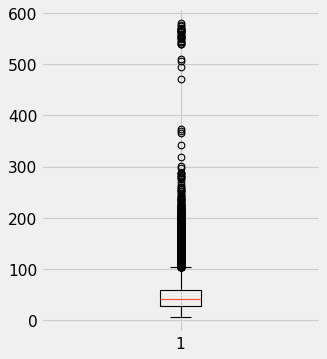

In [162]:
plt.figure(figsize=[4,5], dpi=80)
plt.boxplot([len(s) for s in tag_encoded_list])

In [91]:
print( np.median([len(s) for s in tag_encoded_list]) )
print( np.min([len(s) for s in tag_encoded_list]) )
print( np.max([len(s) for s in tag_encoded_list]) )

40.0
5
581


In [95]:
np.percentile([len(s) for s in tag_encoded_list], 90)

79.0

## Train Model

In [27]:
SEQUENCE_LEN = 80
VOCAB_SIZE = 4769
EMBED_SIZE = 64
N_TAGS = 7

In [30]:
X = pad_sequences(encode_sentence(sentence_list), maxlen=SEQUENCE_LEN)
y = to_categorical( pad_sequences(encode_tag(sentence_tag_list), maxlen=SEQUENCE_LEN), 7)

### Bi-LSTM + CRF

In [278]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy

input = Input(shape=(SEQUENCE_LEN,))
embedding = Embedding(VOCAB_SIZE, EMBED_SIZE)(input)
lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                          recurrent_dropout=0.1))(embedding)
dense = TimeDistributed(Dense(50, activation="relu"))(lstm)
crf = CRF(N_TAGS)
out = crf(dense)

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_accuracy])

In [279]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 64)            305216    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 100)           46000     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 80, 7)             420       
Total params: 356,686
Trainable params: 356,686
Non-trainable params: 0
_________________________________________________________________


In [281]:
history = model.fit(X, y, batch_size=64, epochs=5)

Epoch 1/5
46364/46364 [==============================] - 101s 2ms/step - loss: 0.1069 - crf_accuracy: 0.9622
Epoch 2/5
46364/46364 [==============================] - 101s 2ms/step - loss: 0.0395 - crf_accuracy: 0.9789
Epoch 3/5
46364/46364 [==============================] - 101s 2ms/step - loss: 0.0193 - crf_accuracy: 0.9831
Epoch 4/5
46364/46364 [==============================] - 101s 2ms/step - loss: 0.0050 - crf_accuracy: 0.9854
Epoch 5/5
46364/46364 [==============================] - 101s 2ms/step - loss: -0.0070 - crf_accuracy: 0.9871
